In [1]:

import numpy as np
import astropy.units as u
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))
from importlib import reload
from astropy.io import fits
import copy
import time
from datetime import timezone 

import ray

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize, CenteredNorm
from matplotlib.patches import Circle, Rectangle
from matplotlib.gridspec import GridSpec

import esc_llowfsc_sim
from esc_llowfsc_sim.math_module import xp, xcipy, ensure_np_array
from esc_llowfsc_sim import utils, detector, dm, wfe
import esc_llowfsc_sim.esc_fraunhofer as esc
from esc_llowfsc_sim import llowfsc_sim_rt as llowfsc
from esc_llowfsc_sim import shmim_utils

from magpyx.utils import ImageStream

model_params = utils.load_pickle(esc_llowfsc_sim.path/'data/example_fraunhofer_params_2K.pkl')
wfe_data = utils.load_pickle('flight-sim-data/flight_wfe_data_2K.pkl')
M = esc.single(
    **model_params,
    **wfe_data,
)


/opt/conda/envs/llowfscSim310/lib/python3.10/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


In [7]:
diam = 3.452e-3
wl = 475e-9
fl = 100e-3

pxscl = 4.63e-6

fnum = fl/diam
m_per_lamD = wl*fnum
pxscl_lamD = pxscl/m_per_lamD
pxscl_lamD

0.33647915789473687

In [8]:
diam = 3.452e-3
wl = 475e-9
fl = 150e-3

pxscl = 4.63e-6

fnum = fl/diam
m_per_lamD = wl*fnum
pxscl_lamD = pxscl/m_per_lamD

pxscl_lamD

0.22431943859649123

In [2]:
CAMLO_STREAM = ImageStream('camlosim')
CAMSCI_STREAM = ImageStream('camscisim')

FSM1_STREAM = ImageStream('fsm01')
FSM2_STREAM = ImageStream('fsm02')
DM1_STREAM = ImageStream('dm11disp01')
DM2_STREAM = ImageStream('dm11disp02')
DM3_STREAM = ImageStream('dm11disp03')

LLOWFSC_REF_STREAM = ImageStream('llowfscrefim')
LLOWFSC_GAINS_STREAM = ImageStream('llowfscgains')

FSM2_OFFSET_STREAM = ImageStream('fsm02offset')
DM2_OFFSET_STREAM = ImageStream('dm11disp02offset')

fsm_zeros = np.zeros((1,3))
dm_zeros = np.zeros((model_params['Nact'], model_params['Nact']))

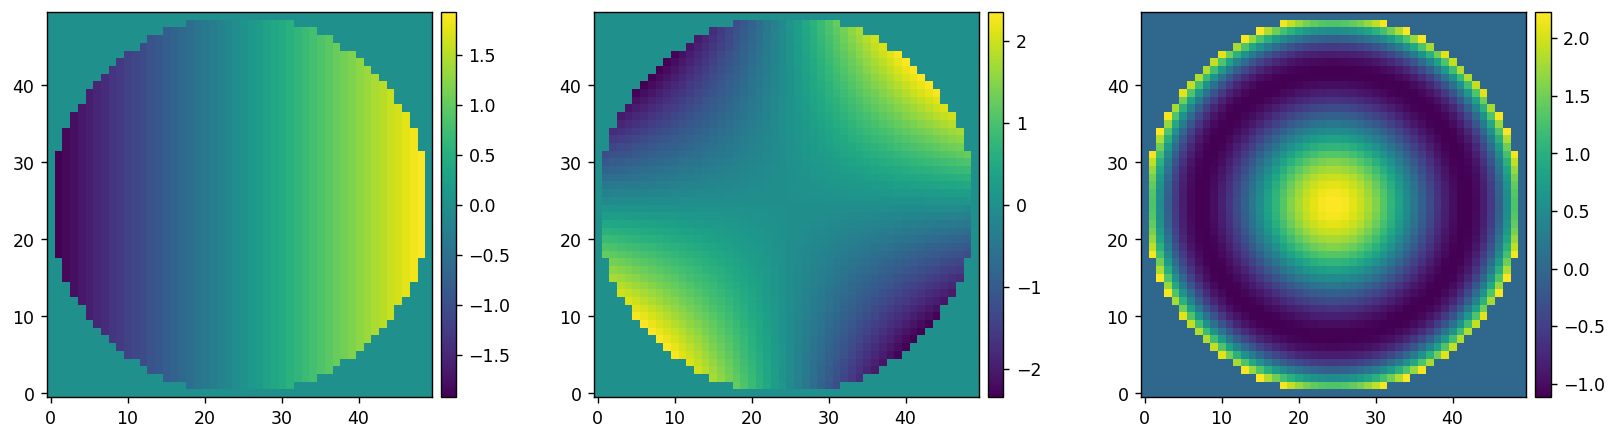

In [3]:
reload(llowfsc)
# calib_data = utils.load_pickle('flight-sim-data/starting_calibration.pkl')
# calib_data = utils.load_pickle('flight-sim-data/ground_calibration.pkl')
calib_data = utils.load_pickle('flight-sim-data/initial_llowfsc_calibration.pkl')
ref_im_flux_norm = ensure_np_array( calib_data['ref_image_flux_norm'])
zer_rm = ensure_np_array( calib_data['zer_response_matrix'] )
# zernike_modes = ensure_np_array(calib_data['zer_modes'])
# zer_modal_matrix = ensure_np_array(calib_data['zer_modal_matrix'])
dm_mask = ensure_np_array(calib_data['dm_mask'])
llowfsc_mask = ensure_np_array(calib_data['llowfsc_mask'])
Nz_modes = zer_rm.shape[1]

dm_zer_mask = ensure_np_array(utils.pad_or_crop(dm.create_mask(Nact=48), model_params['Nact']))
dm_zernike_modes = dm.create_zernike_modes(dm_zer_mask, nmodes=Nz_modes, remove_modes=1, return_np=1)
zer_modal_matrix = dm_zernike_modes.reshape(dm_zernike_modes.shape[0], -1).T
utils.imshow([dm_zernike_modes[0], dm_zernike_modes[3], dm_zernike_modes[-1]], cmaps=3*['viridis'])

z_pinv = np.linalg.pinv(zer_modal_matrix)



In [24]:
shmim_utils.write(FSM2_OFFSET_STREAM, Nz_modes*[0])
shmim_utils.write(DM2_OFFSET_STREAM, Nz_modes*[0])

In [23]:
offset_coeff = np.zeros(Nz_modes)
offset_coeff[1] = 2.5e-3
shmim_utils.write(DM2_OFFSET_STREAM, offset_coeff)

In [4]:
reload(llowfsc)

ff_freq = 200
ff_interval = 1/ff_freq

def update_fsm_offset(
        FSM_STREAM,
        FSM_OFFSET_STREAM,
        fsm_beam_diam,
        Nz_modes,
        # dm_mask,
    ):

    fsm_offset_coeff = 2*utils.tt_as_to_rms( FSM_STREAM.grab_latest()[0][1:], fsm_beam_diam) * 1e6 # make sure FSM command is converted to microns RMS
    offset_coeff = np.pad(fsm_offset_coeff, (0, Nz_modes-2), mode='constant', constant_values=0)

    FSM_OFFSET_STREAM.write( offset_coeff[:,None].T )

def update_dm_offset(
        DM_STREAM,
        DM_OFFSET_STREAM,
        z_pinv,
        # dm_mask,
    ):

    dm_offset_coeff = 2*z_pinv.dot(DM_STREAM.grab_latest().ravel()) # DM command should already be in terms of microns
    DM_OFFSET_STREAM.write( dm_offset_coeff[:,None].T )

def update_manual_ff_offset(
        FSM_STREAM,
        DM_STREAM,
        OFFSET_COEFF_STREAM,
        z_pinv,
        fsm_beam_diam,
        Nz_modes,
        # dm_mask,
    ):

    fsm_offset_coeff = 2*utils.tt_as_to_rms( FSM_STREAM.grab_latest()[0][1:], fsm_beam_diam) * 1e6 # make sure FSM command is converted to microns RMS
    dm_offset_coeff = z_pinv.dot(DM_STREAM.grab_latest().ravel()) # DM command should already be in terms of microns
    offset_coeff = np.pad(fsm_offset_coeff, (0, Nz_modes-2), mode='constant', constant_values=0) + dm_offset_coeff 

    OFFSET_COEFF_STREAM.write( offset_coeff[:,None].T )

fsm_ff_process = llowfsc.Process(
    ff_interval, 
    update_fsm_offset, 
    [FSM2_STREAM,
     FSM2_OFFSET_STREAM,
     model_params['fsm_beam_diam'],
     Nz_modes], # function args
    # function kwargs,
)

dm_ff_process = llowfsc.Process(
    ff_interval, 
    update_dm_offset, 
    [DM2_STREAM,
     DM2_OFFSET_STREAM,
     z_pinv], # function args
    # function kwargs,
)

In [5]:
fsm_ff_process.start()
dm_ff_process.start()

In [59]:
fsm_ff_process.cancel()
dm_ff_process.cancel()

In [37]:
shmim_utils.write(LLOWFSC_GAINS_STREAM, 2*[0.75] + 8*[0.05])

# Test offsets with the FSM.

In [8]:
fsm_command_rms = np.array([[0, -2.5e-9, 0e-9]])
fsm_command_as = utils.tt_rms_to_as(fsm_command_rms, model_params['fsm_beam_diam'])
FSM2_STREAM.write(fsm_command_as)

In [9]:
FSM2_STREAM.write(fsm_zeros)

# Now test offsets with the DM. 

### You can offset tip tilt with the DM as well, but it is better to just use the FSM for those two modes. 

In [27]:
coeff = np.zeros(Nz_modes)
coeff[2] = -2.5e-3
command = np.sum( coeff[:, None, None] * dm_zernike_modes, axis=0)
DM2_STREAM.write(command)

In [29]:
DM2_STREAM.write(dm_zeros)

# Assume we lock onto LLOWFSC first and let it converge to a reasonable state. 

In [92]:
# First we need to aquire a star with LLOWFSC and save the state of the DM command that LLOWFSC initially converges too
llowfsc_command = DM_STREAM1.grab_latest()

# Now record the new reference image if it is in a good state. 

In [68]:
def record_fsm_chops(
        NFRAMES_per_chop,
        chop_amp,
        Nchops,
        delay=0.1,
        plot=False,
    ):

    fsm_responses = np.zeros((2, CAMLO_STREAM.shape[0], CAMLO_STREAM.shape[1]))
    
    for i in range(2):
        print(f'Running chop sequence for mode {i+1:d}.')
        fsm_command_rms = np.zeros((1,3))
        for j in range(Nchops):
            # fsm_command_rms = np.array([[0, chop_amp, 0]])
            print(f'\tApplying positive chop.')
            fsm_command_rms[0, i+1] = chop_amp
            fsm_command_as = llowfsc.fsm_rms_to_as(fsm_command_rms, model_params['fsm_beam_diam'])
            FSM_OFFSET_STREAM.write(fsm_command_as)
            time.sleep(delay)
            im_pos = np.mean(CAMLO_STREAM.grab_many(NFRAMES_per_chop), axis=0)

            print(f'\tApplying negative chop.')
            fsm_command_rms[0, i+1] = -chop_amp
            fsm_command_as = llowfsc.fsm_as_to_rms(fsm_command_rms, model_params['fsm_beam_diam'])
            FSM_OFFSET_STREAM.write(fsm_command_as)
            time.sleep(delay)
            im_neg = np.mean(CAMLO_STREAM.grab_many(NFRAMES_per_chop), axis=0)

            diff_im = (im_pos - im_neg)
            response = diff_im / (2*chop_amp)
            fsm_responses[i] += response/Nchops
            if plot:
                utils.imshow([diff_im])

        FSM_OFFSET_STREAM.write(np.zeros((3,1)).T)
        time

    return fsm_responses

Running chop sequence for mode 1.
	Applying positive chop.
	Applying negative chop.


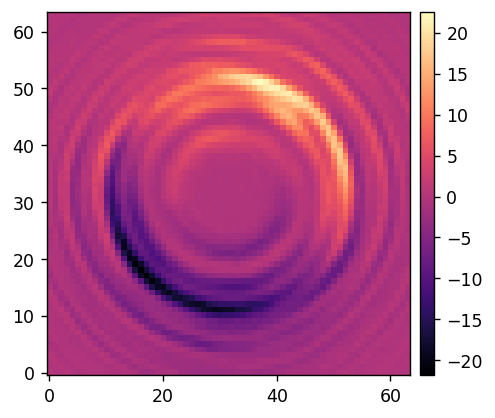

Running chop sequence for mode 2.
	Applying positive chop.
	Applying negative chop.


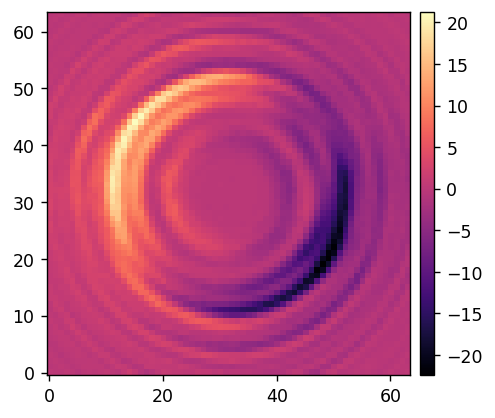

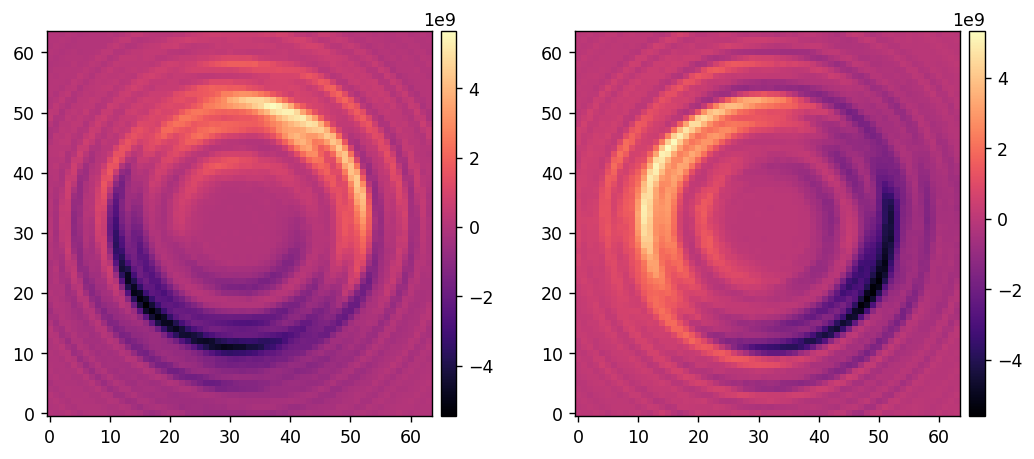

In [70]:
fsm_responses = record_fsm_chops(
    200, 
    2e-9,
    1,
    0.1,
    plot=True, 
)
utils.imshow(
    [fsm_responses[0], fsm_responses[1]]
)